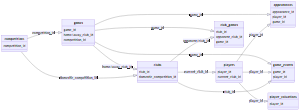


In [3]:
import pandas as pd

df_clubs = pd.read_csv('./data/clubs.csv')
df_game_lineups = pd.read_csv('./data/game_lineups.csv')
df_games = pd.read_csv('./data/games.csv')
df_players = pd.read_csv('./data/players.csv')
df_player_valuations = pd.read_csv('data/player_valuations.csv')

# Processing Transfers
The initial dataset is spread across many tables. I want to organize the data into a form which is most useful to me for predicting the performance of a squad. 

I am also interested in the value of players during transfers. This might be useful for building a model to estimate the cost of a transfer.

Here I create a table of all transfers.

In [37]:
# Step 1: Merge df_game_lineups with df_games to get the date for each game
# Only select the 'game_id', 'date' columns from df_games to reduce merge size
game_lineups_with_date = pd.merge(df_game_lineups[['game_id', 'player_id', 'club_id']], 
                                  df_games[['game_id', 'date']], 
                                  on='game_id')

# Step 2: Merge with df_players to get player details
# Only select the 'player_id' and 'player_name' columns from df_players
player_game_lineups = pd.merge(game_lineups_with_date, 
                               df_players[['player_id', 'name']], 
                               on='player_id')

# Step 3: Merge with df_clubs to get club details
# Only select the 'club_id' and 'club_code' columns from df_clubs
player_club_date = pd.merge(player_game_lineups, 
                            df_clubs[['club_id', 'club_code']], 
                            on='club_id')

# Step 4: Sort by player and date
player_club_date_sorted = player_club_date.sort_values(by=['name', 'date'])

# Step 5: Remove consecutive club entries for each player and include club_id
def remove_consecutive_duplicates_with_date_include_club_id(df):
    # This function will iterate over the dataframe and only keep rows where the club changes
    # It will also collect the date of the change and include club_id
    changes = []
    last_club_code = None
    for _, row in df.iterrows():
        if row['club_code'] != last_club_code:
            changes.append({'club_id': row['club_id'], 'club_code': row['club_code'], 'date': row['date']})
            last_club_code = row['club_code']
    return pd.DataFrame(changes)

# Apply the function to each player's data
player_club_changes = player_club_date_sorted.groupby('player_id').apply(remove_consecutive_duplicates_with_date_include_club_id).reset_index()

# Drop the extra index column
player_club_changes.drop('level_1', axis=1, inplace=True)

C:\Users\ellio\AppData\Local\Temp\ipykernel_26256\2458863057.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_club_changes = player_club_date_sorted.groupby('player_id').apply(remove_consecutive_duplicates_with_date_include_club_id).reset_index()


Here I add the evaluation of a player from the player_valuations table. I capture the date which a player transferred and assign the closest previous evaluation of the player. This is the 'transfer' value.

In [38]:
# Ensure the 'date' column is in datetime format for both dataframes
player_club_changes['date'] = pd.to_datetime(player_club_changes['date'])
df_player_valuations['date'] = pd.to_datetime(df_player_valuations['date'])

# Sort player_valuations by player_id and date to ensure the latest past valuation can be found
df_player_valuations = df_player_valuations.sort_values(by=['player_id', 'date'])

# Function to get the latest market value before the change date
def get_latest_valuation_before_change(row, valuations_df):
    player_id = row['player_id']
    change_date = row['date']
    # Filter valuations for the player and valuation dates before the change date
    past_valuations = valuations_df[(valuations_df['player_id'] == player_id) & 
                                    (valuations_df['date'] <= change_date)]
    if not past_valuations.empty:
        # Get the latest valuation before the change date
        return past_valuations.iloc[-1]['market_value_in_eur']
    else:
        # If no past valuation is found, return NaN or a default value
        return float('nan')

# Apply the function to each row in player_club_changes
player_club_changes['transfer_value'] = player_club_changes.apply(
    lambda row: get_latest_valuation_before_change(row, df_player_valuations), axis=1)

# Merge the player_club_changes with df_players to get the player names and include club_id
final_player_club_history = pd.merge(df_players[['player_id', 'name']], 
                                     player_club_changes[['player_id', 'club_id', 'club_code', 'date', 'transfer_value']], 
                                     on='player_id')

# No need to explode since we are making each transfer its own row
# Convert 'date' to datetime
final_player_club_history['date'] = pd.to_datetime(final_player_club_history['date'])

final_player_club_history.head()

,player_id,name,club_id,club_code,date,transfer_value
0,10,Miroslav Klose,398,lazio-rom,2013-08-18,2000000.0
1,26,Roman Weidenfeller,16,borussia-dortmund,2013-07-27,5000000.0
2,65,Dimitar Berbatov,931,fc-fulham,2013-08-17,5000000.0
3,65,Dimitar Berbatov,162,as-monaco,2014-02-09,3500000.0
4,65,Dimitar Berbatov,1091,paok-thessaloniki,2015-09-12,1000000.0


In [39]:
final_player_club_history[final_player_club_history['name'] == 'Cristiano Ronaldo']


,player_id,name,club_id,club_code,date,transfer_value
1025,8198,Cristiano Ronaldo,418,real-madrid,2013-08-18,100000000.0
1026,8198,Cristiano Ronaldo,506,juventus-turin,2018-08-18,100000000.0
1027,8198,Cristiano Ronaldo,985,manchester-united,2021-09-11,45000000.0


We need to remove player's who occur only once in this dataset as this is not a transfer but simply the first time they played for a club.
We also need to remove the first occurrence of all remaining players since this is again, the first time they played for a club and not a transfer. 
For example, *Cristiano Ronaldo* did not transfer to Real Madrid in 2013, but his first appearance in the game_lineups table.


In [23]:

# Count the occurrences of each player_id
player_counts = final_player_club_history['player_id'].value_counts()

# Filter out player_ids with only one occurrence
players_to_keep = player_counts[player_counts > 1].index

# Keep only the rows with player_ids that have more than one occurrence
final_player_club_history = final_player_club_history[final_player_club_history['player_id'].isin(players_to_keep)]



NameError: name 'final_player_club_history' is not defined

In [41]:
# Correct approach to remove the first occurrence of each player based on date
# Sort the DataFrame by 'name' and 'date' to ensure it's in the right order
final_player_club_history_sorted = final_player_club_history.sort_values(by=['name', 'date'])

# Keep all occurrences of each player except for the first one
# Here, we directly use duplicated() with keep='first' to mark the first occurrence as not a duplicate
# and all others as duplicates, which is the intended behavior to remove the first occurrence
transfer_history = final_player_club_history_sorted[final_player_club_history_sorted.duplicated(subset='name', keep='first')]

# Now, final_player_club_history_filtered correctly contains players without their first occurrence based on date
transfer_history.head()


,player_id,name,club_id,club_code,date,transfer_value
31275,254249,Aaron Appindangoyé,2381,sivasspor,2019-08-17,400000.0
43419,427605,Aaron Boupendza,3349,cd-feirense,2019-08-05,150000.0
43420,427605,Aaron Boupendza,7775,hatayspor,2020-09-21,100000.0
43669,434207,Aaron Connolly,641,fc-middlesbrough,2022-02-04,7000000.0
43670,434207,Aaron Connolly,3008,hull-city,2023-01-07,5000000.0


I save this table and upload it to backblaze to remove the overhead of calculating this each time the app runs. The script so far takes several minutes to run.

In [42]:
transfer_history.to_csv('./data/player_transfer_history.csv')

# Processing Player Performances

The next table I want to create is a table of all player performances over the course of a season. It would be useful for creating a model that predicts squad performance if I have a table of players and their performances, their team, the season they played, the squad of players they played with in a season, and other useful metrics.

In [192]:
import numpy as np
transfer_history = pd.read_csv('./data/player_transfer_history.csv')
df_appearances = pd.read_csv('data/appearances.csv')

Looking through the code projects in Kaggle I found a very useful function for generating stats for an individual player. I have adapted this function to generate stats for every player in every season. 

player_stats function credit: https://www.kaggle.com/code/marekkamm7/stats-by-season

In [44]:
def player_stats(player_name, season):
    
    df = df_appearances.merge(df_games, on=['game_id'], how='left')
    df = df[df['player_name'] == player_name]  
    df = df[df['season'] == season]
    
    if (df.shape[0] == 0):
        Out = [(np.nan, player_name, season, 0, 0, 0, 0, 0, 0, 0)]
        out_df = pd.DataFrame(data=Out, columns=['player_id', 'player_name', 'season', 'goals', 'games',
                                                 'assists', 'minutes_played', 'goals_for', 'goals_against', 'clean_sheet'])
        return out_df
    
    else:
        
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
                      else 0 if row['goals_against'] > 0
                      else np.nan, axis=1)
        
        df = df.groupby(['player_id', "player_name", "season"], as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played': 'sum', 'goals_for': 'sum',
                                                                      'goals_against': 'sum', 'clean_sheet': 'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        
        return out_df

In [45]:
#player_stats('Cristiano Ronaldo', 2022)

In [193]:
def all_players_season_stats():
    # Merge appearances with games and clubs to include club information
    df_merged = df_appearances.merge(df_games, on='game_id', how='left').merge(df_clubs, left_on='player_club_id', right_on='club_id', how='left')
    
    # Calculate goals for and against, and clean sheets
    df_merged["goals_for"] = df_merged.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                                             else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                                             else np.nan, axis=1)
    df_merged["goals_against"] = df_merged.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                                                 else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                                                 else np.nan, axis=1)
    df_merged['clean_sheet'] = df_merged.apply(lambda row: 1 if row['goals_against'] == 0
                                               else 0 if row['goals_against'] > 0
                                               else np.nan, axis=1)
    
    # Group by player, season, and club to aggregate stats
    grouped_df = df_merged.groupby(['player_id', 'player_name', 'season', 'club_code', 'club_id'], as_index=False).agg({
        'goals': 'sum', 
        'game_id': 'nunique', 
        'assists': 'sum', 
        'minutes_played': 'sum', 
        'goals_for': 'sum',
        'goals_against': 'sum', 
        'clean_sheet': 'sum'
    }).rename(columns={'game_id': 'games'})
    
    return grouped_df

In [194]:
player_history = all_players_season_stats()

In [195]:
player_history.head()

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13


Next I want to add player evaluations to each player. This evaluation is the closest in time to the evaluation at the end of the season, May 31st, in player_valuations table.

In [196]:
def combine_player_stats_and_valuations(player_season_stat, player_valuations):
    # Convert 'season' to datetime to match with the valuation dates
    # Assuming the season ends on May 31st of the following year
    player_season_stat['season_end_date'] = pd.to_datetime((player_season_stat['season'] + 1).astype(str) + '-05-31')
    
    # Prepare player_valuations by ensuring 'date' is in datetime format
    player_valuations['date'] = pd.to_datetime(player_valuations['date'])
    
    # Initialize an empty DataFrame to store the combined data
    combined_data = []

    # Iterate over each row in player_season_stat to find the corresponding valuation
    for index, row in player_season_stat.iterrows():
        player_id = row['player_id']
        season_end_date = row['season_end_date']
        
        # Filter valuations for the player and valuation dates before the season end date
        filtered_valuations = player_valuations[(player_valuations['player_id'] == player_id) & 
                                                (player_valuations['date'] <= season_end_date)]
        
        # Sort the filtered valuations by date and select the last one (closest to season end)
        latest_valuation = filtered_valuations.sort_values(by='date', ascending=False).head(1)
        
        # If there's a valuation, extract the market value; otherwise, set it as NaN
        market_value = latest_valuation['market_value_in_eur'].values[0] if not latest_valuation.empty else float('nan')
        
        # Append the combined data with the market value
        combined_data.append(row.tolist() + [market_value])
    
    # Define the column names for the combined DataFrame
    combined_columns = player_season_stat.columns.tolist() + ['season_end_valuation']
    
    # Create a DataFrame from the combined data
    combined_df = pd.DataFrame(combined_data, columns=combined_columns)
    
    return combined_df

In [197]:
player_history = combine_player_stats_and_valuations(player_history, df_player_valuations)
player_history.head()

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_date,season_end_valuation
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,2013-05-31,4000000.0
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,2014-05-31,1000000.0
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,2015-05-31,1000000.0
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,2016-05-31,1000000.0
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,2013-05-31,4000000.0


This column is uneccessary to keep.

In [198]:
player_history.drop(columns=['season_end_date'], inplace=True)
player_history.head()


,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,4000000.0
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,1000000.0
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,1000000.0
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,1000000.0
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,4000000.0


It is useful to have the position a player played in a particular season.

In [199]:
# Merge player_stat_valuations with df_players to append position and sub-position
player_history = pd.merge(player_history, df_players[['player_id', 'position', 'sub_position']], on='player_id', how='left')


In [158]:
df_competitions = pd.read_csv('data/competitions.csv')

It is useful to know what domestic league the player is playing in. This could help the model understand that some leagues are more difficult to play in than others.

In [200]:
# Assuming df_clubs has columns 'club_id' and 'domestic_competition_id' for the league information
player_history = pd.merge(player_history, df_clubs[['club_id', 'domestic_competition_id']], on='club_id', how='left')

# Rename 'domestic_competition_id' to 'league' for clarity
player_history.rename(columns={'domestic_competition_id': 'league'}, inplace=True)

In [201]:
player_history.head()

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation,position,sub_position,league
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,4000000.0,Attack,Centre-Forward,IT1
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,1000000.0,Attack,Centre-Forward,IT1
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,1000000.0,Attack,Centre-Forward,IT1
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,1000000.0,Attack,Centre-Forward,IT1
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,4000000.0,Goalkeeper,Goalkeeper,L1


Here I add the age of the player.

In [202]:
# Calculate the age of the player during the season
# First, merge player_history with df_players to get the date_of_birth
player_history = pd.merge(player_history, df_players[['player_id', 'date_of_birth']], on='player_id', how='left')

# Convert 'date_of_birth' and 'season' to datetime objects
player_history['date_of_birth'] = pd.to_datetime(player_history['date_of_birth'])
# Assuming the season starts on July 1st of the 'season' year
player_history['season_start_date'] = pd.to_datetime(player_history['season'].astype(str) + '-07-01')

# Calculate age by subtracting the date_of_birth from the season_start_date and converting to days, then divide by 365.25 to get years
player_history['age'] = ((player_history['season_start_date'] - player_history['date_of_birth']) / np.timedelta64(1, 'D') / 365.25)

# Use np.floor to round down the age and handle NaN values gracefully
player_history['age'] = np.floor(player_history['age']).astype('Int64')

# Drop the 'date_of_birth' and 'season_start_date' columns as they are no longer needed
player_history.drop(columns=['date_of_birth', 'season_start_date'], inplace=True)

player_history.head()

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation,position,sub_position,league,age
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,4000000.0,Attack,Centre-Forward,IT1,34
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,1000000.0,Attack,Centre-Forward,IT1,35
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,1000000.0,Attack,Centre-Forward,IT1,36
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,1000000.0,Attack,Centre-Forward,IT1,37
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,4000000.0,Goalkeeper,Goalkeeper,L1,31


Again I have saved this table and uploaded it to backblaze to remove the overhead of running this every time the app runs.

In [203]:
player_history.to_csv('./data/player_history.csv', index=False)

In [178]:
player_history = pd.read_csv('./data/player_history.csv')

Now that I have a dataset of the history of every player, I want to group them by squads so that I can build a model that predicts squad performance. To do this, I create a new key called squad_id that takes the club_id and the season to create a new composite key

In [204]:
# Convert club_id to int to ensure consistent formatting, then create squad_id as an integer by combining club_id and season
player_history['squad_id'] = (player_history['club_id'].astype(int).astype(str) + player_history['season'].astype(str)).astype(int)



I need to normalize the size of squads. To do this I need to set bounds on the number of players in each position in each squad, however I also want the maximum number of players total. I need to strike a balance between the size of squads and the number of players that are represented.

In [180]:
# Count the number of players in each position for each squad
position_counts = player_history.groupby(['squad_id', 'position']).size().unstack(fill_value=0)

# Find the squad with the least number of attackers, midfielders, defenders, and goalkeepers
min_attackers = position_counts['Attack'].idxmin()
min_midfielders = position_counts['Midfield'].idxmin()
min_defenders = position_counts['Defender'].idxmin()
min_goalkeepers = position_counts['Goalkeeper'].idxmin()

# Get the number of players in the least squads
num_attackers = position_counts['Attack'].min()
num_midfielders = position_counts['Midfield'].min()
num_defenders = position_counts['Defender'].min()
num_goalkeepers = position_counts['Goalkeeper'].min()

# Display the results
print(f"Squad with the least number of attackers: {min_attackers}, Number: {num_attackers}")
print(f"Squad with the least number of midfielders: {min_midfielders}, Number: {num_midfielders}")
print(f"Squad with the least number of defenders: {min_defenders}, Number: {num_defenders}")
print(f"Squad with the least number of goalkeepers: {min_goalkeepers}, Number: {num_goalkeepers}")


avg_attackers = position_counts['Attack'].mean()
avg_midfielders = position_counts['Midfield'].mean()
avg_defenders = position_counts['Defender'].mean()
avg_goalkeepers = position_counts['Goalkeeper'].mean()

# Display the averages
print(f"Average number of attackers per squad: {avg_attackers}")
print(f"Average number of midfielders per squad: {avg_midfielders}")
print(f"Average number of defenders per squad: {avg_defenders}")
print(f"Average number of goalkeepers per squad: {avg_goalkeepers}")

Squad with the least number of attackers: 42015, Number: 0
Squad with the least number of midfielders: 32012, Number: 0
Squad with the least number of defenders: 32012, Number: 0
Squad with the least number of goalkeepers: 32012, Number: 0
Average number of attackers per squad: 6.936599423631124
Average number of midfielders per squad: 7.357348703170029
Average number of defenders per squad: 8.143804034582132
Average number of goalkeepers per squad: 1.9579250720461094


Here I calculate the optimal number of players in each position to maximize the number of player represented.

In [205]:

# Find the combination of num_att, num_mid, num_def, and num_goalk that leads to the highest num_players value
max_num_players = 0
best_combination = {}

# Iterate through possible values for each position
for num_att in range(1, 12):  # Assuming a practical upper limit for attackers
    for num_mid in range(1, 12):  # Assuming a practical upper limit for midfielders
        for num_def in range(1, 12):  # Assuming a practical upper limit for defenders
            for num_goalk in range(1, 4):  # Assuming a practical upper limit for goalkeepers
                # Filter squads that meet the current criteria
                squad_criteria = position_counts[(position_counts['Attack'] >= num_att) & 
                                                 (position_counts['Midfield'] >= num_mid) & 
                                                 (position_counts['Defender'] >= num_def) & 
                                                 (position_counts['Goalkeeper'] >= num_goalk)]
                # Count the number of squads that meet the criteria
                num_squads_meeting_criteria = len(squad_criteria)
                num_players = (num_att + num_mid + num_def + num_goalk) * num_squads_meeting_criteria
                
                # Update max_num_players and best_combination if current num_players is higher
                if num_players > max_num_players:
                    max_num_players = num_players
                    best_combination = {'Attackers': num_att, 'Midfielders': num_mid, 'Defenders': num_def, 'Goalkeepers': num_goalk}

# Display the best combination and the resulting number of players
print(f"Best combination: {best_combination}")
print(f"Maximum number of players in all squads: {max_num_players}")


Best combination: {'Attackers': 5, 'Midfielders': 6, 'Defenders': 7, 'Goalkeepers': 1}
Maximum number of players in all squads: 50141


This particular number of players in each position maximizes the number of players available while also normalizing the number of players in a squad. This will be useful for when we build our model and knowing constitutes a 'squad'

One issue with this particular method is that it hurts big clubs with lots of players. There could be a player who is very good, possibly better than most players, but the aren't included in the model because they are not one of the 5 main attackers in the squad. Big clubs also usually have more than one goalkeeper, and if a squad uses two goalkeepers than the second goalkeeper will not be properly accounted for in the performance of the squad.

A better method would to use a model that can account for any size squad of players.

# Squad Constructor

The next phase is to construct a dataset of squads. This is a similar dataset to player_history, except it only include the most 'relevant' players to a squad, which are the players who have the most appearances in their position. If a player has the same appearances as another player in their position, tie breakers are done by number of goals + assist for attackers, goals + assists + clean_sheets for midfielders, assists + clean sheets for defenders, and clean sheets for goalkeepers.

In [206]:
# Ensure this step is executed successfully before filtering squads
player_history['squad_id'] = (player_history['club_id'].astype(int).astype(str) + player_history['season'].astype(str)).astype(int)

# Now, proceed with filtering squads as intended
min_players_criteria = {'Attackers': 5, 'Midfielders': 6, 'Defenders': 7, 'Goalkeepers': 1}
filtered_squads = position_counts[(position_counts['Attack'] >= min_players_criteria['Attackers']) & 
                                  (position_counts['Midfield'] >= min_players_criteria['Midfielders']) & 
                                  (position_counts['Defender'] >= min_players_criteria['Defenders']) & 
                                  (position_counts['Goalkeeper'] >= min_players_criteria['Goalkeepers'])]

squads_df = player_history[player_history['squad_id'].isin(filtered_squads.index)]

In [208]:
# Define the criteria for each position
position_criteria = {
    'Attack': 5,
    'Midfield': 6,
    'Defender': 7,
    'Goalkeeper': 1
}

# Function to filter top players based on games played and tie-breaker criteria
def filter_top_players(group):
    filtered_group = pd.DataFrame()
    for position, top_n in position_criteria.items():
        # Sort by minutes played, then by goals + assists + clean sheets for tie-breaking
        sorted_group = group[group['position'] == position].sort_values(by=['minutes_played', 'goals', 'assists', 'clean_sheet'], ascending=[False, False, False, False])
        # Use head to get the top_n players after sorting
        filtered_group = pd.concat([filtered_group, sorted_group.head(top_n)])
    return filtered_group

# Apply the function to each squad
top_players_per_squad = squads_df.groupby('squad_id').apply(filter_top_players).reset_index(drop=True)


C:\Users\ellio\AppData\Local\Temp\ipykernel_6828\803043646.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_players_per_squad = squads_df.groupby('squad_id').apply(filter_top_players).reset_index(drop=True)


An example of what a single squad looks like. Each squad, indicated by squad_id, will have 5 attackers, 6 midfielders, 7 defenders, and 1 goalkeeper, all of which are the players with the most minutes played in their position type.

In [209]:
top_players_per_squad[(top_players_per_squad['club_code'] == 'manchester-united') & (top_players_per_squad['season'] == 2018)]

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation,position,sub_position,league,age,squad_id
26524,258923,Marcus Rashford,2018,manchester-united,985.0,13,47,11,3292,76,61,11,80000000.0,Attack,Left Winger,GB1,20,9852018
26525,96341,Romelu Lukaku,2018,manchester-united,985.0,15,44,4,2911,67,58,12,85000000.0,Attack,Centre-Forward,GB1,25,9852018
26526,182877,Anthony Martial,2018,manchester-united,985.0,12,37,3,2238,54,52,8,60000000.0,Attack,Centre-Forward,GB1,22,9852018
26527,40433,Alexis Sánchez,2018,manchester-united,985.0,2,27,4,1240,40,30,9,45000000.0,Attack,Centre-Forward,GB1,29,9852018
26528,532826,Mason Greenwood,2018,manchester-united,985.0,0,2,0,105,2,3,0,NaN,Attack,Right Winger,GB1,16,9852018
26529,122153,Paul Pogba,2018,manchester-united,985.0,16,47,11,4012,72,60,11,90000000.0,Midfield,Central Midfield,GB1,25,9852018
26530,74683,Nemanja Matic,2018,manchester-united,985.0,1,37,0,3247,63,46,10,35000000.0,Midfield,Defensive Midfield,GB1,29,9852018
26531,141660,Jesse Lingard,2018,manchester-united,985.0,5,35,3,2140,54,47,7,40000000.0,Midfield,Attacking Midfield,GB1,25,9852018
26532,99343,Ander Herrera,2018,manchester-united,985.0,3,27,3,1824,51,31,7,28000000.0,Midfield,Central Midfield,GB1,28,9852018
26533,44068,Juan Mata,2018,manchester-united,985.0,5,31,4,1710,51,37,8,25000000.0,Midfield,Attacking Midfield,GB1,30,9852018


When the user types in a team, this will be the squad of players that is inputted into the model.

In [210]:
top_players_per_squad.to_csv('./data/squad_history.csv')

In [211]:
team_list = top_players_per_squad['club_code'].unique().tolist()
team_list

['1-fc-koln',
 '1-fc-nurnberg',
 'ac-mailand',
 'adanaspor',
 'arminia-bielefeld',
 'fc-arsenal',
 'as-rom',
 'atletico-madrid',
 'bayer-04-leverkusen',
 'borussia-dortmund',
 'borussia-monchengladbach',
 'brescia-calcio',
 'bursaspor',
 'eintracht-braunschweig',
 'eintracht-frankfurt',
 'fc-bayern-munchen',
 'fc-everton',
 'fc-liverpool',
 'fc-schalke-04',
 'fenerbahce-istanbul',
 'fortuna-dusseldorf',
 '1-fsv-mainz-05',
 'fc-girondins-bordeaux',
 'hamburger-sv',
 'hannover-96',
 'heart-of-midlothian-fc',
 'hertha-bsc',
 'inter-mailand',
 'iraklis-thessaloniki',
 'rsc-anderlecht',
 'sc-freiburg',
 'spvgg-greuther-furth',
 'vfb-stuttgart',
 'vfl-bochum',
 'vfl-wolfsburg',
 'sv-werder-bremen',
 '1-fc-union-berlin',
 'sv-darmstadt-98',
 'besiktas-istanbul',
 'dinamo-moskau',
 'glasgow-rangers',
 'caykur-rizespor',
 'sc-paderborn-07',
 'ao-xanthi',
 'parma-calcio-1913',
 'fc-barcelona',
 'nac-breda',
 'sc-cambuur-leeuwarden',
 'galatasaray-istanbul',
 'real-saragossa',
 'tottenham-hotspur

In [212]:
selected_team = 'manchester-united'
season = 2018
selected_squad = top_players_per_squad[(top_players_per_squad['club_code'] == selected_team) & (top_players_per_squad['season'] == season)]
selected_squad

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation,position,sub_position,league,age,squad_id
26524,258923,Marcus Rashford,2018,manchester-united,985.0,13,47,11,3292,76,61,11,80000000.0,Attack,Left Winger,GB1,20,9852018
26525,96341,Romelu Lukaku,2018,manchester-united,985.0,15,44,4,2911,67,58,12,85000000.0,Attack,Centre-Forward,GB1,25,9852018
26526,182877,Anthony Martial,2018,manchester-united,985.0,12,37,3,2238,54,52,8,60000000.0,Attack,Centre-Forward,GB1,22,9852018
26527,40433,Alexis Sánchez,2018,manchester-united,985.0,2,27,4,1240,40,30,9,45000000.0,Attack,Centre-Forward,GB1,29,9852018
26528,532826,Mason Greenwood,2018,manchester-united,985.0,0,2,0,105,2,3,0,NaN,Attack,Right Winger,GB1,16,9852018
26529,122153,Paul Pogba,2018,manchester-united,985.0,16,47,11,4012,72,60,11,90000000.0,Midfield,Central Midfield,GB1,25,9852018
26530,74683,Nemanja Matic,2018,manchester-united,985.0,1,37,0,3247,63,46,10,35000000.0,Midfield,Defensive Midfield,GB1,29,9852018
26531,141660,Jesse Lingard,2018,manchester-united,985.0,5,35,3,2140,54,47,7,40000000.0,Midfield,Attacking Midfield,GB1,25,9852018
26532,99343,Ander Herrera,2018,manchester-united,985.0,3,27,3,1824,51,31,7,28000000.0,Midfield,Central Midfield,GB1,28,9852018
26533,44068,Juan Mata,2018,manchester-united,985.0,5,31,4,1710,51,37,8,25000000.0,Midfield,Attacking Midfield,GB1,30,9852018


In [213]:
# Shuffle the DataFrame
top_players_per_squad = top_players_per_squad.sample(frac=1).reset_index(drop=True)

# Define a custom order for positions
position_order = {'Attack': 1, 'Midfield': 2, 'Defender': 3, 'Goalkeeper': 4}

# Map the custom order to a new column for sorting
top_players_per_squad['position_order'] = top_players_per_squad['position'].map(position_order)

# Sort the DataFrame by squad_id, position_order, and minutes_played
top_players_per_squad_sorted = top_players_per_squad.sort_values(by=['squad_id', 'position_order', 'minutes_played'], ascending=[True, True, False])

# Drop unnecessary columns before pivoting
columns_to_drop = ['player_name', 'club_code', 'goals', 'games', 'assists', 'minutes_played', 'goals_for', 'goals_against', 'clean_sheet', 'season_end_valuation', 'sub_position']
top_players_per_squad_sorted.drop(columns=columns_to_drop, inplace=True)

# Generate a unique identifier for each player within their squad for pivoting
top_players_per_squad_sorted['player_rank'] = top_players_per_squad_sorted.groupby('squad_id').cumcount() + 1

# Pivot 'player_id' and 'age' columns
player_ids_pivot = top_players_per_squad_sorted.pivot(index='squad_id', columns='player_rank', values='player_id').add_prefix('player_id_')
ages_pivot = top_players_per_squad_sorted.pivot(index='squad_id', columns='player_rank', values='age').add_prefix('age_')

# Merge the pivoted DataFrames back together
squad_wide_format = player_ids_pivot.join(ages_pivot).reset_index()

# Extract unique squad identifiers (season, league, club_id, squad_id) and drop duplicates
squad_identifiers = top_players_per_squad_sorted[['squad_id', 'season', 'league', 'club_id']].drop_duplicates()

# Merge the squad identifiers with the wide format DataFrame
final_squad_df = pd.merge(squad_identifiers, squad_wide_format, on='squad_id', how='inner')

final_squad_df['league_code'] = final_squad_df['league'].astype('category').cat.codes
#drop league column
final_squad_df = final_squad_df.drop(columns='league')

# Now, final_squad_df contains each squad as a single row with player_ids and ages spread across columns,
# along with unique identifiers for each squad

In [174]:
# Normalize the player_id, age, season, and league columns in final_squad_df while maintaining the uniqueness of each value within the player id columns
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Extract player_id columns for normalization while maintaining uniqueness
player_id_columns = [col for col in final_squad_df.columns if 'player_id_' in col]

# Create a temporary DataFrame to hold normalized player_id values
temp_player_ids = final_squad_df[player_id_columns].copy()

# Normalize each player_id column separately to maintain uniqueness
for column in player_id_columns:
    # Reshape for MinMaxScaler
    reshaped_vals = temp_player_ids[column].values.reshape(-1, 1)
    # Normalize and update the temporary DataFrame
    temp_player_ids[column] = scaler.fit_transform(reshaped_vals)

# Update the original DataFrame with normalized player_id columns
final_squad_df[player_id_columns] = temp_player_ids

# Normalize age columns
age_columns = [col for col in final_squad_df.columns if 'age_' in col]
final_squad_df[age_columns] = scaler.fit_transform(final_squad_df[age_columns])

# Normalize 'season' column
final_squad_df['season'] = scaler.fit_transform(final_squad_df[['season']])

# Normalize 'season' column
final_squad_df['club_id'] = scaler.fit_transform(final_squad_df[['club_id']])

# Assuming 'league_code' has already been created and you're now normalizing it
# Normalize 'league_code' column
final_squad_df['league_code'] = final_squad_df['league_code'].astype(float)  # Ensure it's the correct type for normalization
final_squad_df['league_code'] = scaler.fit_transform(final_squad_df[['league_code']])

# Since the 'league' column has been used to create 'league_code', now you can safely drop it if it exists
if 'league' in final_squad_df.columns:
    final_squad_df = final_squad_df.drop(columns='league')

In [214]:
df_games['home_squad_id'] = (df_games['home_club_id'].astype(int).astype(str) + df_games['season'].astype(str)).astype(int)
df_games['away_squad_id'] = (df_games['away_club_id'].astype(int).astype(str) + df_games['season'].astype(str)).astype(int)


# Initialize the squad_performance DataFrame
squad_performance_columns = ['squad_id', 'wins', 'draws', 'loss', 'goals_scored', 'goals_conceded', 'clean_sheets']
squad_performance = pd.DataFrame(columns=squad_performance_columns)

# Calculate wins, draws, loss, goals scored, goals conceded, and clean sheets for home and away games
home_metrics = df_games.groupby('home_squad_id').apply(lambda x: pd.Series({
    'wins': (x['home_club_goals'] > x['away_club_goals']).sum(),
    'draws': (x['home_club_goals'] == x['away_club_goals']).sum(),
    'loss': (x['home_club_goals'] < x['away_club_goals']).sum(),
    'goals_scored': x['home_club_goals'].sum(),
    'goals_conceded': x['away_club_goals'].sum(),
    'clean_sheets': (x['away_club_goals'] == 0).sum()
})).reset_index().rename(columns={'home_squad_id': 'squad_id'})

away_metrics = df_games.groupby('away_squad_id').apply(lambda x: pd.Series({
    'wins': (x['away_club_goals'] > x['home_club_goals']).sum(),
    'draws': (x['home_club_goals'] == x['away_club_goals']).sum(),
    'loss': (x['away_club_goals'] < x['home_club_goals']).sum(),
    'goals_scored': x['away_club_goals'].sum(),
    'goals_conceded': x['home_club_goals'].sum(),
    'clean_sheets': (x['home_club_goals'] == 0).sum()
})).reset_index().rename(columns={'away_squad_id': 'squad_id'})

# Combine home and away metrics for each squad
squad_performance = pd.concat([home_metrics, away_metrics]).groupby('squad_id').sum().reset_index()

# Calculate various team performance statistics
squad_performance['points'] = squad_performance['wins'] * 3 + squad_performance['draws'] * 1
squad_performance['total_games'] = squad_performance['wins'] + squad_performance['draws'] + squad_performance['loss']
squad_performance['win_rate'] = squad_performance['wins'] / squad_performance['total_games']
squad_performance['loss_rate'] = squad_performance['loss'] / squad_performance['total_games']
squad_performance['goal_difference'] = squad_performance['goals_scored'] - squad_performance['goals_conceded']
squad_performance['avg_goals_scored_per_game'] = squad_performance['goals_scored'] / squad_performance['total_games']
squad_performance['avg_goals_conceded_per_game'] = squad_performance['goals_conceded'] / squad_performance['total_games']
squad_performance['clean_sheet_rate'] = squad_performance['clean_sheets'] / squad_performance['total_games']
squad_performance['goals_scored_per_win'] = squad_performance.apply(lambda x: x['goals_scored'] / x['wins'] if x['wins'] > 0 else 0, axis=1)
squad_performance['goals_conceded_per_loss'] = squad_performance.apply(lambda x: x['goals_conceded'] / x['loss'] if x['loss'] > 0 else 0, axis=1)

# Example squad performance data - Barcelona 2015
squad_performance[squad_performance['squad_id'] == 9852017]

C:\Users\ellio\AppData\Local\Temp\ipykernel_6828\2878858381.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  home_metrics = df_games.groupby('home_squad_id').apply(lambda x: pd.Series({
C:\Users\ellio\AppData\Local\Temp\ipykernel_6828\2878858381.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  away_metrics = df_games.groupby('away_squad_id').apply(lambda x: pd.Series({


,squad_id,wins,draws,loss,goals_scored,goals_conceded,clean_sheets,points,total_games,win_rate,loss_rate,goal_difference,avg_goals_scored_per_game,avg_goals_conceded_per_game,clean_sheet_rate,goals_scored_per_win,goals_conceded_per_loss
3083,9852017,35,7,11,94,37,27,112,53,0.660377,0.207547,57,1.773585,0.698113,0.509434,2.685714,3.363636


In [215]:
final_merged_df = pd.merge(final_squad_df, squad_performance, on='squad_id', how='inner')
final_merged_df = final_merged_df.dropna()

In [217]:
final_merged_df.to_csv('./data/squad_and_performance.csv')